In [1]:
import os                       # for working with files
import numpy as np              # for numerical computationss
import pandas as pd             # for working with dataframes
import matplotlib.pyplot as plt # for plotting informations on graph and images using tensors
import torch.nn as nn           # for creating  neural networks
from torch.utils.data import DataLoader # for dataloaders 
from PIL import Image           # for checking images
import torch.nn.functional as F # for functions for calculating loss
import torchvision.transforms as transforms   # for transforming images into tensors 
from torchvision.utils import make_grid       # for data checking
from torchvision.datasets import ImageFolder  # for working with classes and images
from torchsummary import summary              # for getting the summary of our model
from efficientnet_pytorch import EfficientNet
import torch
from torch.optim.lr_scheduler import StepLR
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from efficientnet_pytorch import EfficientNet
from torchvision.datasets import ImageFolder
from sklearn.metrics import f1_score
import torch.optim as optim


%matplotlib inline

In [2]:
# for moving data into GPU (if available)
def get_default_device():  # sourcery skip: assign-if-exp
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available:
        return torch.device("cuda")
    else:
        return torch.device("cpu")


In [5]:
print(get_default_device())

cuda


In [86]:
data_dir = 'D:/project_cardomom/Cardamom_disease_dataset(Augmented)'
train_dir = data_dir + "/train"
valid_dir = data_dir + "/valid"
diseases = os.listdir(train_dir)
print(diseases)


In [87]:
# printing the disease names
print(diseases)

['Cardamom___Healthy', 'Cardamom___LeafBlight', 'Cardamom___LeafSpot']


In [88]:
plants = []
NumberOfDiseases = 0
for plant in diseases:
    if plant.split('___')[0] not in plants:
        plants.append(plant.split('___')[0])
    if plant.split('___')[1] != 'healthy':
        NumberOfDiseases += 1
        

In [89]:
# printing the disease names
print(diseases)
# number of unique plants
print(f"Number of plants: {len(plants)}")
# number of unique diseases
print(f"Number of diseases: {NumberOfDiseases}")

['Cardamom___Healthy', 'Cardamom___LeafBlight', 'Cardamom___LeafSpot']
Number of plants: 1
Number of diseases: 3


In [90]:
import torchvision.datasets as datasets
import pandas as pd

# Directory paths containing your image datasets
data_dirs = [
    'D:/project_cardomom/Cardamom_disease_dataset(Augmented)/train/Cardamom___Healthy',
    'D:/project_cardomom/Cardamom_disease_dataset(Augmented)/train/Cardamom___LeafBlight',
    'D:/project_cardomom/Cardamom_disease_dataset(Augmented)/train/Cardamom___LeafSpot'
]

class_names = [
    'Cardamom___Healthy',
    'Cardamom___LeafBlight',
    'Cardamom___LeafSpot'
]

img_per_class = {}

# Count the number of images per class
for class_name, data_dir in zip(class_names, data_dirs):
    dataset = datasets.ImageFolder(data_dir)
    print(len(dataset))
    num_images = len(dataset)
    img_per_class[class_name] = num_images

# Create a DataFrame to display the results
img_per_class_df = pd.DataFrame({"No. of Images": img_per_class})
print(img_per_class_df)



722
603
643
                       No. of Images
Cardamom___Healthy               722
Cardamom___LeafBlight            603
Cardamom___LeafSpot              643


In [91]:
# datasets for validation and training
train = ImageFolder(train_dir, transform=transforms.ToTensor())
valid = ImageFolder(valid_dir, transform=transforms.ToTensor()) 

In [92]:
img, label = train[0]
print(img.shape, label)

torch.Size([3, 320, 320]) 0


In [93]:
# total number of classes in train set
len(train.classes)

3

In [94]:
# for checking some images from training dataset
def show_image(image, label):
    print(f"Label :{train.classes[label]}({str(label)})")
    plt.imshow(image.permute(1, 2, 0))

Label :Cardamom___Healthy(0)


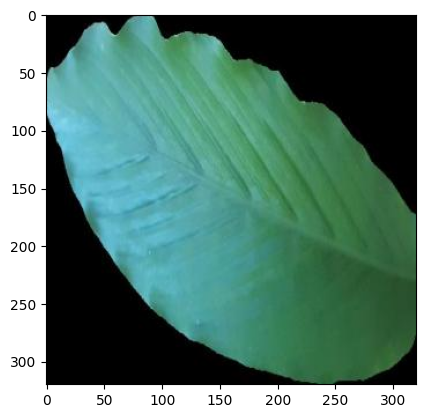

In [95]:
show_image(*train[0])

In [96]:
# Setting the seed value
random_seed = 7
random_seed=torch.manual_seed(random_seed)

In [97]:
#setting batch_size
batch_size = 8

In [98]:
# DataLoaders for training and validation
train_dl = DataLoader(train, batch_size, shuffle=True, num_workers=2, pin_memory=True)
valid_dl = DataLoader(valid, batch_size, num_workers=2, pin_memory=True)

In [99]:
# helper function to show a batch of training instances
def show_batch(data):
    for images, labels in data:
        fig, ax = plt.subplots(figsize=(30, 30))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=8).permute(1, 2, 0))
        break

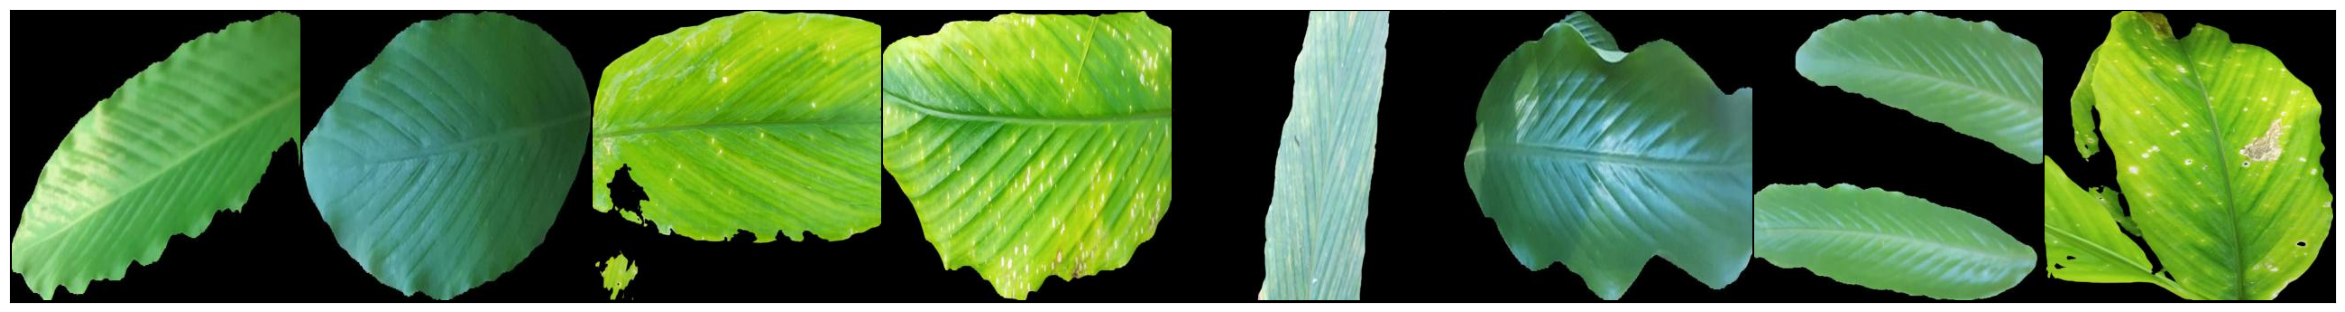

In [100]:
# Images for first batch of training
show_batch(train_dl) 

In [101]:
# for moving data into GPU (if available)
def get_default_device():  # sourcery skip: assign-if-exp
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available:
        return torch.device("cuda")
    else:
        return torch.device("cpu")

# for moving data to device (CPU or GPU)
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

# for loading in the device (GPU if available else CPU)
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)
        
    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [102]:
#Setting the device
device = get_default_device()
device

device(type='cuda')

In [103]:
# Moving data into GPU
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

In [104]:


class EfficientNetBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.efficientnet = EfficientNet.from_pretrained('efficientnet-b4')
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.conv2(out)
        out = self.relu2(out)
        out = self.efficientnet(out)
        return out + x


In [105]:
# for calculating the accuracy
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [106]:





# base class for the model
class ImageClassificationBase(nn.Module):
    
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        return F.cross_entropy(out, labels)
    
    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                   # Generate prediction
        loss = F.cross_entropy(out, labels)  # Calculate loss
        acc = accuracy(out, labels)          # Calculate accuracy
        return {"val_loss": loss.detach(), "val_accuracy": acc}
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x["val_loss"] for x in outputs]
        batch_accuracy = [x["val_accuracy"] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()       # Combine loss  
        epoch_accuracy = torch.stack(batch_accuracy).mean()
        return {"val_loss": epoch_loss, "val_accuracy": epoch_accuracy} # Combine accuracies
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_accuracy']))
        
        
class EfficientNetBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.efficientnet = EfficientNet.from_pretrained('efficientnet-b4')
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.conv2(out)
        out = self.relu2(out)
        out = self.efficientnet(out)
        return out + x
    
    
class EfficientNetClassifier(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.block1 = EfficientNetBlock()
        self.block2 = EfficientNetBlock()
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(1792, 10)
        
    def forward(self, x):
        out = self.block1(x)
        out = self.block2(out)
        out = self.pool(out)
        out = out.view(-1, 1792)
        out = self.fc(out)
        return out


In [107]:
class EfficientNetB4(ImageClassificationBase):
    def __init__(self, num_classes):
        super().__init__()
        self.model = EfficientNet.from_pretrained('efficientnet-b4')
        self.model._fc = nn.Linear(in_features=1792, out_features=num_classes, bias=True)
    
    def forward(self, xb):
        return self.model(xb)

In [108]:
model = to_device(EfficientNetB4(len(train.classes)), device)

Loaded pretrained weights for efficientnet-b4


In [109]:
INPUT_SHAPE = (3, 256, 256)


In [110]:
# for training
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)



def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
    

def fit_OneCycle(epochs, max_lr, model, train_loader, val_loader, weight_decay,
                grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # scheduler for one cycle learniing rate
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))
    
    
    for epoch in range(epochs):
        # Training
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
                
            optimizer.step()
            optimizer.zero_grad()
            
            # recording and updating learning rates
            lrs.append(get_lr(optimizer))
            sched.step()
        
        
            
    
        # validation
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
        
    return history
    

In [111]:
history = [evaluate(model, valid_dl)]

In [105]:
opt_func = torch.optim.RMSprop
epochs = 50
max_lr = 0.001
grad_clip = 1

In [106]:
%%time
history += fit_OneCycle(epochs, max_lr, model, train_dl, valid_dl,
                            weight_decay=1e-2, 
                            grad_clip=grad_clip, 
                            opt_func=opt_func)


Epoch [0], last_lr: 0.00005, train_loss: 0.3541, val_loss: 4.1301, val_acc: 0.3064
Epoch [1], last_lr: 0.00008, train_loss: 0.2594, val_loss: 4.3047, val_acc: 0.3064
Epoch [2], last_lr: 0.00013, train_loss: 0.2508, val_loss: 4.7261, val_acc: 0.3064
Epoch [3], last_lr: 0.00020, train_loss: 0.2761, val_loss: 2.4935, val_acc: 0.3064
Epoch [4], last_lr: 0.00028, train_loss: 0.3565, val_loss: 1.4584, val_acc: 0.3669
Epoch [5], last_lr: 0.00037, train_loss: 0.3533, val_loss: 1.1910, val_acc: 0.3669
Epoch [6], last_lr: 0.00047, train_loss: 0.4010, val_loss: 1.6171, val_acc: 0.5412
Epoch [7], last_lr: 0.00057, train_loss: 0.3789, val_loss: 1.3728, val_acc: 0.3669
Epoch [8], last_lr: 0.00067, train_loss: 0.3743, val_loss: 3.0220, val_acc: 0.3669
Epoch [9], last_lr: 0.00076, train_loss: 0.3626, val_loss: 2.9210, val_acc: 0.3064
Epoch [10], last_lr: 0.00084, train_loss: 0.3512, val_loss: 2.8124, val_acc: 0.3064
Epoch [11], last_lr: 0.00091, train_loss: 0.3331, val_loss: 1.1393, val_acc: 0.4954
Ep

In [111]:
def plot_accuracies(history):
    accuracies = [x['val_accuracy'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')

def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'].cpu().numpy() for x in history]  # Move tensors to CPU and convert to numpy arrays

    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.')

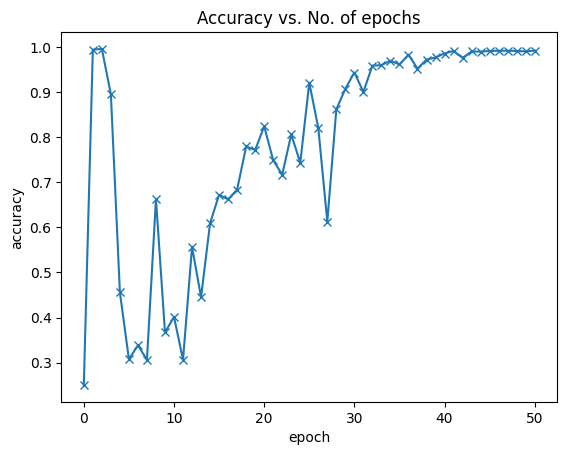

In [112]:
plot_accuracies(history)

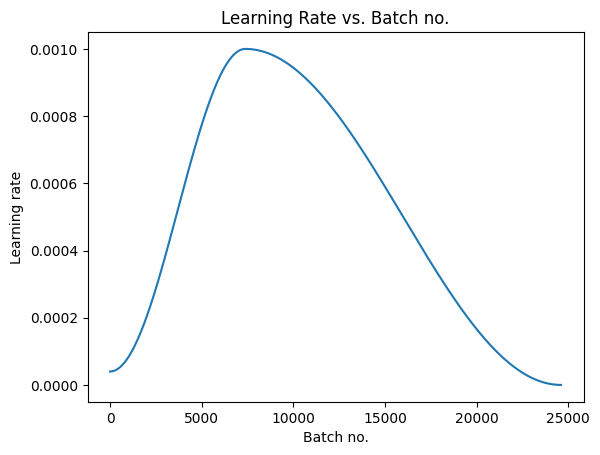

In [113]:
plot_lrs(history)

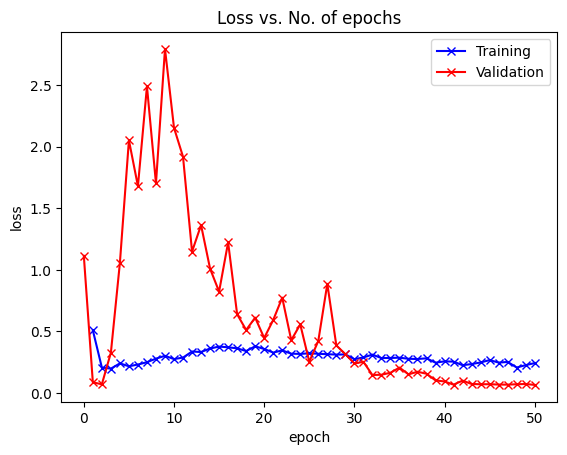

In [114]:
plot_losses(history)


In [112]:
test_dir = "D:/project_cardomom/Test_images"
test = ImageFolder(test_dir, transform=transforms.ToTensor())

In [113]:
test_images = sorted(os.listdir(f'{test_dir}/test'))
test_images

['Cardmom_HL_1.jpg',
 'Cardmom_HL_2.jpg',
 'Cardmom_HL_3.jpg',
 'Cardmom_HL_4.jpg',
 'Cardmom_HL_5.jpg',
 'Cardmom_HL_6.jpg',
 'Cardmom_HL_7.jpg',
 'Leaf_blight_1.JPG',
 'Leaf_blight_3.JPG',
 'Leaf_blight_4.JPG',
 'Leaf_blight_5.JPG',
 'Leaf_blight_6.JPG',
 'Leaf_blight_8.JPG',
 'leaf_spot_1.jpg',
 'leaf_spot_2.jpg',
 'leaf_spot_3.jpg',
 'leaf_spot_4.jpg',
 'leaf_spot_5.jpg',
 'leaf_spot_6.jpg',
 'leaf_spot_7.jpg',
 'leaf_spot_8.jpg']

In [114]:
def predict_image(img, model):
    """Converts image to array and return the predicted class
        with highest probability and the confidence score"""
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Move xb to the same device as the model
    xb = xb.to(next(model.parameters()).device)
    # Get predictions from model
    yb = model(xb)
    # Compute probabilities from logits
    probabilities = torch.softmax(yb, dim=1)
    # Get the predicted class index
    _, preds = torch.max(probabilities, dim=1)
    # Get the confidence score for the predicted class
    confidence = probabilities[0, preds.item()].item()
    # Retrieve the class label
    predicted_class = train.classes[preds.item()]
    
    return predicted_class, confidence


In [118]:
for i, (img, label) in enumerate(test):
    print('Label:', test_images[i], ', Predicted:', predict_image(img, model))
#Ouput on training time

Label: Cardmom_HL_1.jpg , Predicted: ('Cardamom___Healthy', 0.9733202457427979)
Label: Cardmom_HL_2.jpg , Predicted: ('Cardamom___Healthy', 0.9816117882728577)
Label: Cardmom_HL_3.jpg , Predicted: ('Cardamom___Healthy', 0.9468842148780823)
Label: Cardmom_HL_4.jpg , Predicted: ('Cardamom___Healthy', 0.9622988104820251)
Label: Cardmom_HL_5.jpg , Predicted: ('Cardamom___Healthy', 0.9739950299263)
Label: Cardmom_HL_6.jpg , Predicted: ('Cardamom___Healthy', 0.9497073292732239)
Label: Cardmom_HL_7.jpg , Predicted: ('Cardamom___Healthy', 0.9789080619812012)
Label: Leaf_blight_1.JPG , Predicted: ('Cardamom___LeafBlight', 0.9554787874221802)
Label: Leaf_blight_3.JPG , Predicted: ('Cardamom___LeafBlight', 0.9614750146865845)
Label: Leaf_blight_4.JPG , Predicted: ('Cardamom___LeafBlight', 0.9614750146865845)
Label: Leaf_blight_5.JPG , Predicted: ('Cardamom___LeafBlight', 0.9725928902626038)
Label: Leaf_blight_6.JPG , Predicted: ('Cardamom___LeafBlight', 0.8498764634132385)
Label: Leaf_blight_8.JP

Label: Leaf_blight_3.JPG , Predicted: Cardamom___LeafBlight , Confidence: 0.9614750146865845


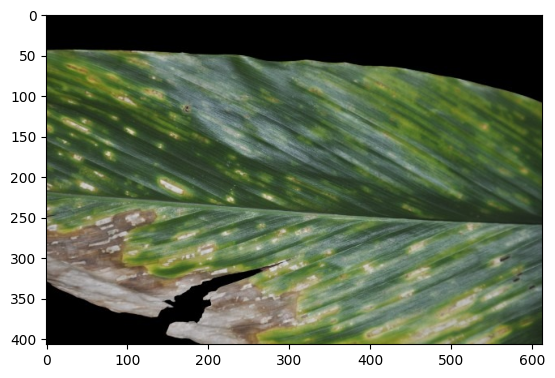

In [119]:
# predicting first image
img, label = test[8]
plt.imshow(img.permute(1, 2, 0))
predicted_class, confidence = predict_image(img, model)
print('Label:', test_images[8], ', Predicted:', predicted_class, ', Confidence:', confidence)
#trining

In [120]:
#trained_model=model
#torch.save(trained_model.state_dict(), 'my_efv4_cardamom_update.pt')

In [117]:
loaded_model =model
loaded_model.load_state_dict(torch.load('my_efv4_cardamom_update.pt'))

<All keys matched successfully>

In [118]:
# getting all predictions (actual label vs predicted)
for i, (img, label) in enumerate(test):
    print('Label:', test_images[i], ', Predicted:', predict_image(img,loaded_model))

Label: Cardmom_HL_1.jpg , Predicted: ('Cardamom___Healthy', 0.9733202457427979)
Label: Cardmom_HL_2.jpg , Predicted: ('Cardamom___Healthy', 0.9816117882728577)
Label: Cardmom_HL_3.jpg , Predicted: ('Cardamom___Healthy', 0.9468842148780823)
Label: Cardmom_HL_4.jpg , Predicted: ('Cardamom___Healthy', 0.9622988104820251)
Label: Cardmom_HL_5.jpg , Predicted: ('Cardamom___Healthy', 0.9739950299263)
Label: Cardmom_HL_6.jpg , Predicted: ('Cardamom___Healthy', 0.9497073292732239)
Label: Cardmom_HL_7.jpg , Predicted: ('Cardamom___Healthy', 0.9789080619812012)
Label: Leaf_blight_1.JPG , Predicted: ('Cardamom___LeafBlight', 0.9554787874221802)
Label: Leaf_blight_3.JPG , Predicted: ('Cardamom___LeafBlight', 0.9614750146865845)
Label: Leaf_blight_4.JPG , Predicted: ('Cardamom___LeafBlight', 0.9614750146865845)
Label: Leaf_blight_5.JPG , Predicted: ('Cardamom___LeafBlight', 0.9725928902626038)
Label: Leaf_blight_6.JPG , Predicted: ('Cardamom___LeafBlight', 0.8498764634132385)
Label: Leaf_blight_8.JP

Label: Leaf_blight_1.JPG , Predicted: Cardamom___LeafBlight , Confidence: 0.9554787874221802


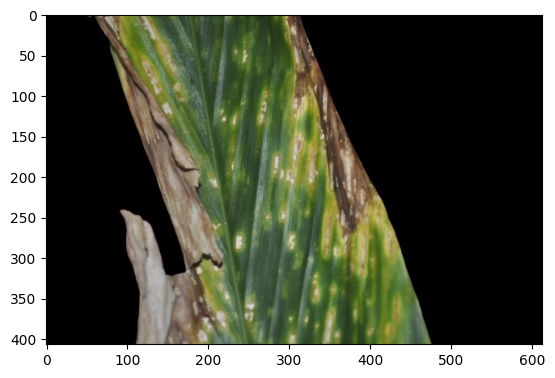

In [119]:

# Set the model to evaluation mode
loaded_model.eval()

# Use the model to make predictions on new data
# predicting first image
img, label = test[7]
plt.imshow(img.permute(1, 2, 0))
predicted_class, confidence = predict_image(img, model)
print('Label:', test_images[7], ', Predicted:', predicted_class, ', Confidence:', confidence)




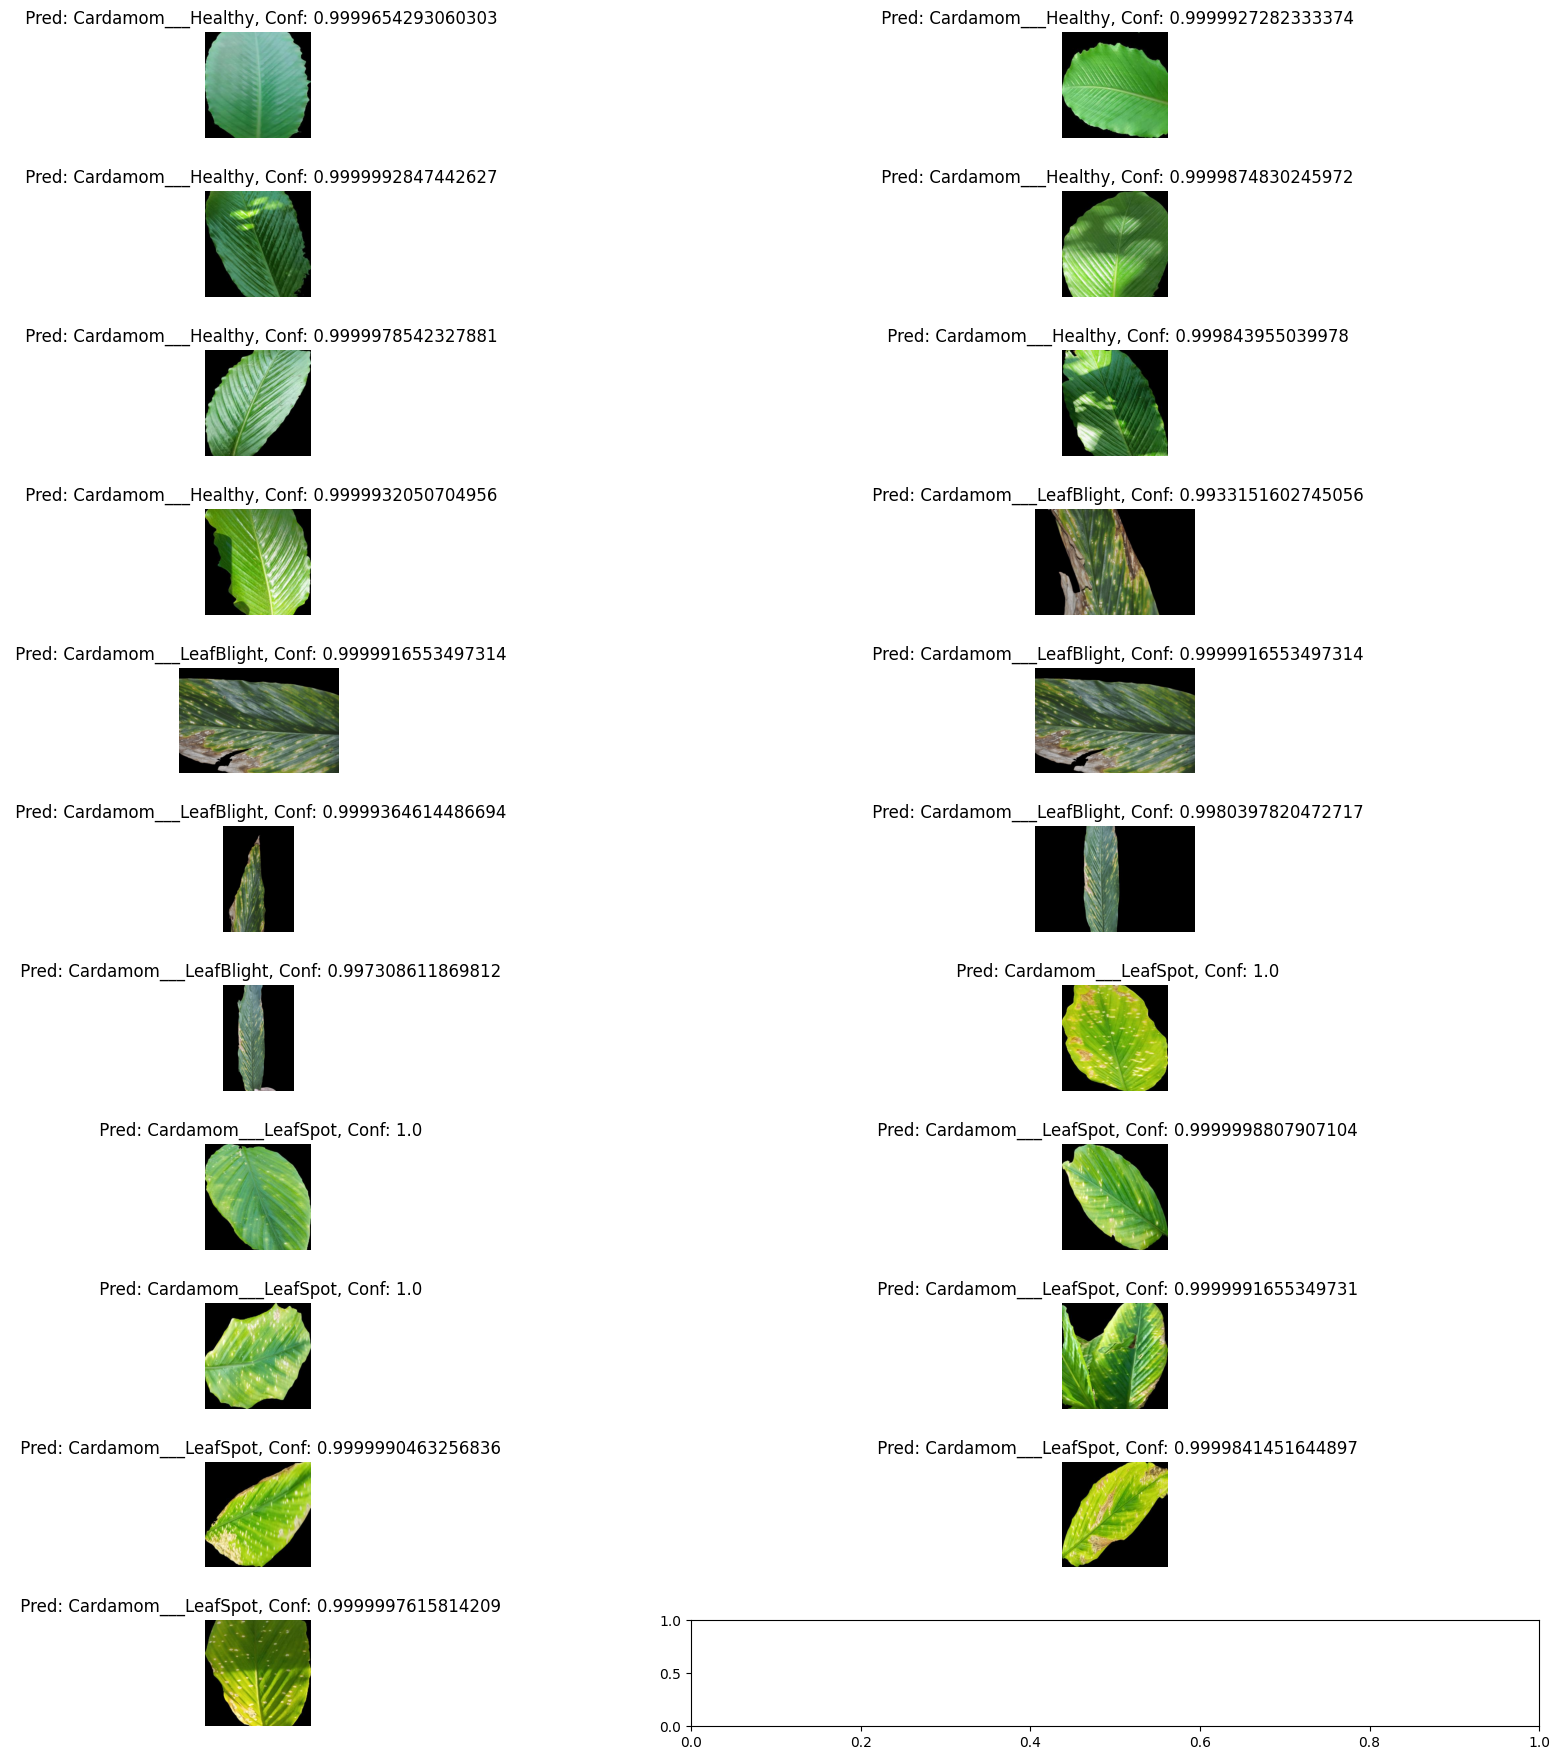

In [53]:
import math

# Calculate the number of rows and columns for the subplot grid
num_images = len(test)
rows = math.ceil(num_images / 2)
cols = min(num_images, 2)

# Create a subplot grid
fig, axs = plt.subplots(rows, cols, figsize=(22, 22))
axs = axs.flatten()

# Iterate over test dataset
for i, (img, label) in enumerate(test):
    # Display image
    axs[i].imshow(img.permute(1, 2, 0))
    axs[i].axis('off')

    # Get predicted class and confidence
    predicted_class, confidence = predict_image(img, model)
    axs[i].set_title(f" Pred: {predicted_class}, Conf: {confidence}")

    # Break loop if all subplots are filled
    if i+1 >= rows * cols:
        break

# Adjust spacing between subplots

plt.subplots_adjust(wspace=.01, hspace=.5)
# Show the plot
plt.show()
